In [8]:
%matplotlib inline

import os
import random

import matplotlib.pyplot as plt
import numpy as np
from netpyne import specs, sim

folder = 'Ground truth SWCs'

cells = 10
exitatory_frac = 0.8

netParams = specs.NetParams()
netParams.sizeX = 100             # x-dimension (horizontal length) size in um
netParams.sizeY = 100            # y-dimension (vertical height or cortical depth) size in um
netParams.sizeZ = 10
netParams.propVelocity = 5.0    # propagation velocity (um/ms)
netParams.probLengthConst = 150.0


swc_filenames = []
for file in os.listdir(folder):
    if os.path.splitext(file)[-1] == '.swc':
        swc_filenames.append(file)

print(swc_filenames)
num_pops = len(swc_filenames)

cell_labels = []
E_list = []
I_list = []
for ii, swc_fname in enumerate(swc_filenames):
    label = f'swc_{ii:04d}'
    
    cellRule = netParams.importCellParams(
        label=label, 
        conds={'cellType': 'Traced'},
        fileName=os.path.join(folder, swc_fname), 
        cellName=label,
        )
    
    cell_labels.append(label)
    
    # For convenience, we'll rename the first soma section in the morphology from `soma_0` to `soma`.
    netParams.renameCellParamsSec(label, 'soma_0', 'soma')
    

    for secName in cellRule['secs']:
        cellRule['secs'][secName]['geom']['cm'] = 1
        if secName.startswith('soma'):
            cellRule['secs'][secName]['mechs']['hh'] = {
                'gnabar': 0.12, 
                'gkbar': 0.036, 
                'gl': 0.003, 
                'el': -70,
                }
        else:
            cellRule['secs'][secName]['mechs']['hh'] = {
                'gnabar': 0.12, 
                'gkbar': 0.036, 
                'gl': 0.003, 
                'el': -70,
                }
    X = random.randint(0, netParams.sizeX-1)
    Y = random.randint(0, netParams.sizeY-1)
    Z = random.randint(0, netParams.sizeZ-1)
    
    cellRule['x'] = X
    cellRule['y'] = Y
    cellRule['z'] = Z
        
    # Now we'll make a population out of our imported cell.
    # netParams.popParams[ii] = {'cellType': 'swc_cell', 'numCells': 1}
    
    if random.random() < exitatory_frac:
        pop_list = E_list
    else:
        pop_list = I_list
        
    pop_list.append(cellRule)

netParams.popParams['E'] = {'cellType'  : 'Traced',
                            'cellsList' : E_list,
                              'numCells': int(cells/num_pops)}

netParams.popParams['I'] = {'cellType'  : 'Traced',
                            'cellsList' : I_list,
                              'numCells': int(cells/num_pops)}


['Image10.rnp.swc', 'Image31.rnp.swc', 'Image4.rnp.swc', 'Image5.rnp.swc', 'Image7.rnp.swc', 'Series17.rnp.swc', 'Series19.rnp.swc', 'Series21.rnp.swc', 'Series9.rnp.swc']


In [9]:
len(netParams.popParams['I'])

3

In [10]:
## Synaptic mechanism parameters
netParams.synMechParams['exc'] = {'mod': 'Exp2Syn', 'tau1': 0.8, 'tau2': 5.3, 'e': 0}  # NMDA synaptic mechanism
netParams.synMechParams['inh'] = {'mod': 'Exp2Syn', 'tau1': 0.6, 'tau2': 8.5, 'e': -75}  # GABA synaptic mechanism

# Stimulation parameters
netParams.stimSourceParams['bkg'] = {'type': 'NetStim', 'rate': 20, 'noise': 0.3}
netParams.stimTargetParams['bkg->all'] = {'source': 'bkg', 'conds': {'cellType': 'Traced'}, 'weight': 0.01, 'delay': 'max(1, normal(5,2))', 'synMech': 'exc'}

stim_ii = random.randint(0, cells-1)
print(f'Cell # {stim_ii} is stimulated')

netParams.stimSourceParams['Probe'] = {'type': 'NetStim', 'rate': 10}
netParams.stimTargetParams['Probe->Cell'] = {'source': 'Probe', 'conds': {'cellList': [stim_ii]}, 'weight': 0.5, 'delay': '30', 'synMech': 'exc'}

Cell # 5 is stimulated


In [11]:
# Distance-based connectivity
netParams.connParams['E->E'] = {
    'preConds': {'pop': 'E'}, 
    'postConds': {'pop': 'E'},
    'probability': '1*exp(-dist_3D/probLengthConst)',                  # probability of connection
    'weight': '0.60',         # synaptic weight
    'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
    'synMech': 'exc'}                     # synaptic mechanism

netParams.connParams['E->I'] = {
    'preConds': {'pop': 'E'}, 
    'postConds': {'pop': 'I'},  
    'probability': '1*exp(-dist_3D/probLengthConst)',                  # probability of connection
    'weight': '0.60',         # synaptic weight
    'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
    'synMech': 'exc'}                     # synaptic mechanism

netParams.connParams['I->E'] = {
    'preConds': {'pop': 'I'}, 
    'postConds': {'pop': 'E'},  #  E -> all (100-1000 um)
    'probability': '0.6*exp(-dist_3D/probLengthConst)',                  # probability of connection
    'weight': '0.01',         # synaptic weight
    'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
    'synMech': 'inh'}                     # synaptic mechanism

netParams.connParams['I->I'] = {
    'preConds': {'pop': 'I'}, 
    'postConds':  {'pop': 'I'},  #  E -> all (100-1000 um)
    'probability': '0.6*exp(-dist_3D/probLengthConst)',                  # probability of connection
    'weight': '0.01',         # synaptic weight
    'delay': 'dist_3D/propVelocity',      # transmission delay (ms)
    'synMech': 'inh'}                     # synaptic mechanism


Start time:  2022-05-23 14:36:38.326531

Creating network of 2 cell populations on 1 hosts...
  Number of cells on node 0: 9 
  Done; cell creation time = 5.77 s.
Making connections...
  Number of connections on node 0: 44 
  Done; cell connection time = 0.01 s.
Adding stims...
  Number of stims on node 0: 10 
  Done; cell stims creation time = 0.00 s.
Recording 9 traces of 1 types on node 0

Running simulation using NEURON for 400.0 ms...
  Done; run time = 0.68 s; real-time ratio: 0.59.

Gathering data...
  Done; gather time = 0.23 s.

Analyzing...
  Cells: 9
  Connections: 53 (5.89 per cell)
  Synaptic contacts: 54 (6.00 per cell)
  Spikes: 40 (11.11 Hz)
  Simulated time: 0.4 s; 1 workers
  Run time: 0.68 s
Saving output as tut5_data.pkl ... 
Finished saving!
  Done; saving time = 2.03 s.
Preparing spike data...
Plotting raster...
Plotting recorded cell traces ... trace


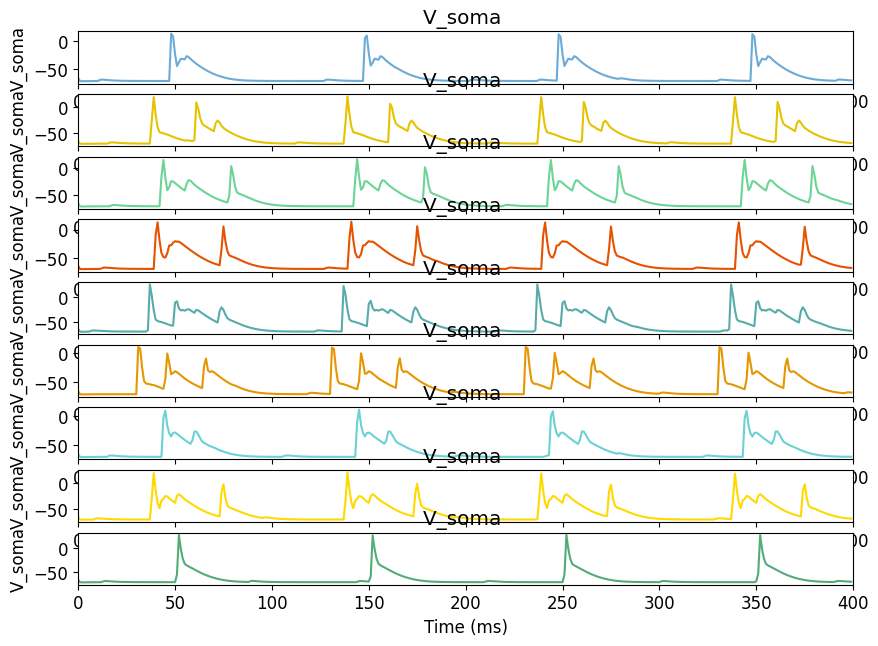

Plotting 2D representation of network cell locations and connections...


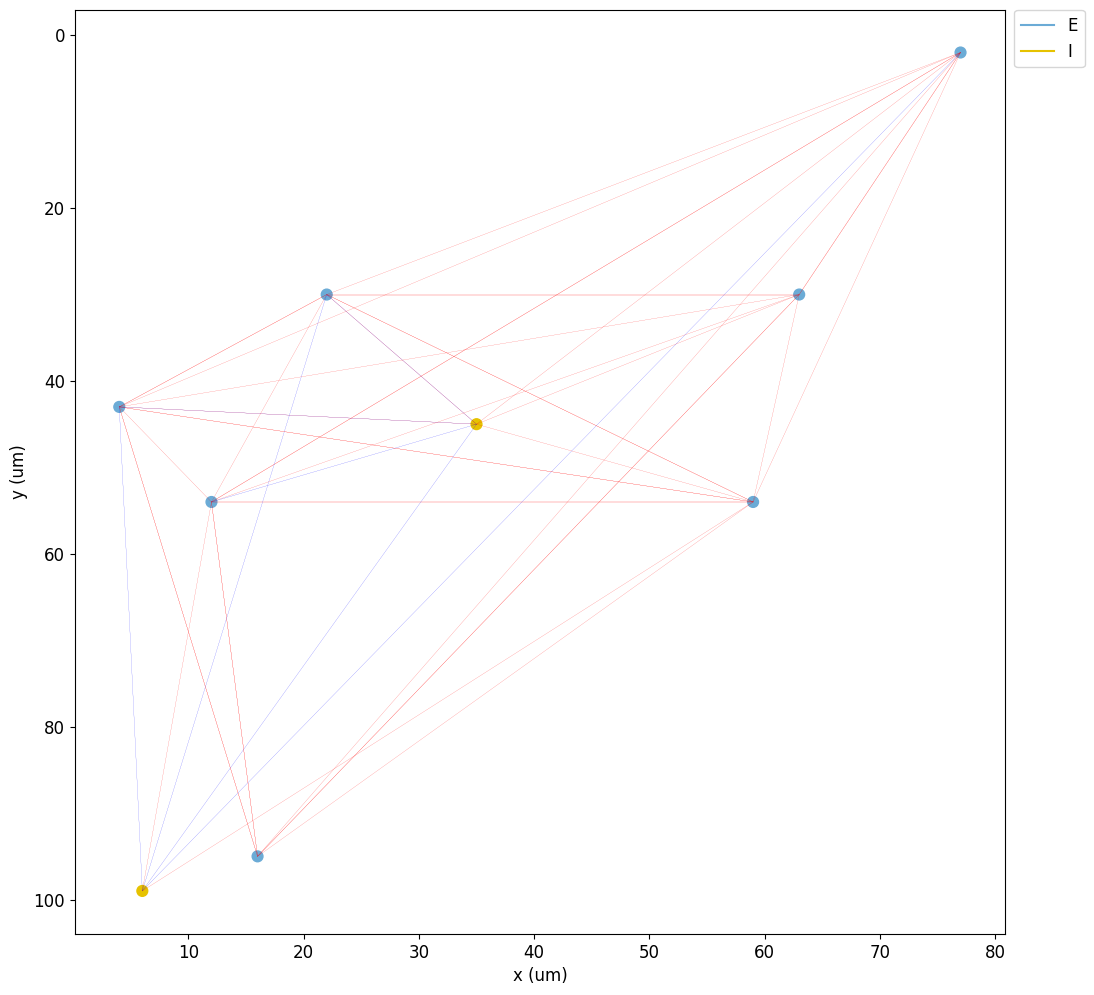

Plotting connectivity matrix...


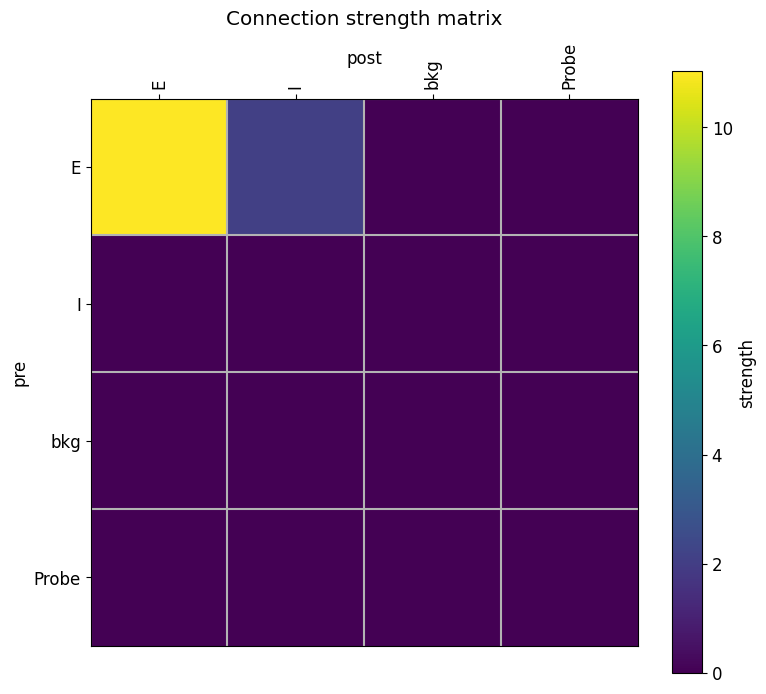

  Done; plotting time = 1.58 s

Total time = 10.31 s


In [12]:
# Simulation options
simConfig = specs.SimConfig()        # object of class SimConfig to store simulation configuration

simConfig.duration = 0.4*1e3           # Duration of the simulation, in ms
simConfig.dt = 0.05                  # Internal integration timestep to use
simConfig.verbose = False            # Show detailed messages
simConfig.recordTraces = {'V_soma':{'sec':'soma','loc':0.5,'var':'v'}}  # Dict with traces to record
simConfig.recordCells = range(cells)
simConfig.recordStep = 1             # Step size in ms to save data (e.g. V traces, LFP, etc)
simConfig.filename = 'tut5'          # Set file output name
simConfig.savePickle = True         # Save params, network and sim output to pickle file

simConfig.analysis['plotRaster'] = {'orderBy': 'y', 'orderInverse': True, 'saveFig': True}         # Plot a raster
simConfig.analysis['plotTraces'] = {'oneFigPer' : 'trace' ,'saveFig': True}  # Plot recorded traces for this list of cells
simConfig.analysis['plot2Dnet'] = {'saveFig': True}                                                # plot 2D cell positions and connections
simConfig.analysis['plotConn'] = {'saveFig': True}                                                 # plot connectivity matrix

# Create network and run simulation
sim.createSimulateAnalyze(netParams = netParams, simConfig = simConfig)

In [13]:
sim.net.pops

{E: <netpyne.network.pop.Pop object at 0x000002188C6E0BB0>, I: <netpyne.network.pop.Pop object at 0x000002188C705040>}

Text(0, 0.5, 'Neuron #')

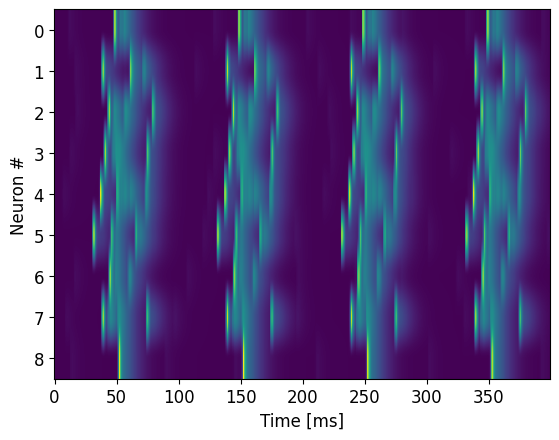

In [14]:
data = []
for key, value in sim.simData['V_soma'].items():
    if key[0] is not '_':
        data.append(list(value))
        
data = np.array(data)

plt.imshow(data, aspect='auto', interpolation=None)
plt.xlabel('Time [ms]')
plt.ylabel('Neuron #')